# XGB Model



 ## Import



In [12]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tnrange, tqdm_notebook

from xgboost  import XGBRegressor, plot_importance
import xgboost as xgb

import eli5 
from eli5.sklearn import PermutationImportance

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('font', family='AppleGothic')
import warnings
warnings.filterwarnings('ignore')


In [11]:
pip install eli5

  Using cached eli5-0.13.0-py2.py3-none-any.whl
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
train= pd.read_csv("DATA/train.csv")
test= pd.read_csv("data/test.csv")


In [14]:
del_col = ['ID']
enc_col = [ '브랜드', '차량모델명', '판매도시','판매구역']

In [15]:
train = train.drop(columns = del_col)
test = test.drop(columns = del_col)

## Encoder

In [16]:
for i in enc_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    train[i]=le.transform(train[i])
    test[i]=le.transform(test[i])

## X_train, y_train

In [17]:
y_train = train['가격']
X_train = train.drop(columns=['가격'])

In [35]:
X_train_k=X_train.copy()
y_train_k=y_train.copy()

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                    test_size=0.2, random_state=42)

In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(46336, 13) (46336,)
(11584, 13) (11584,)


## Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

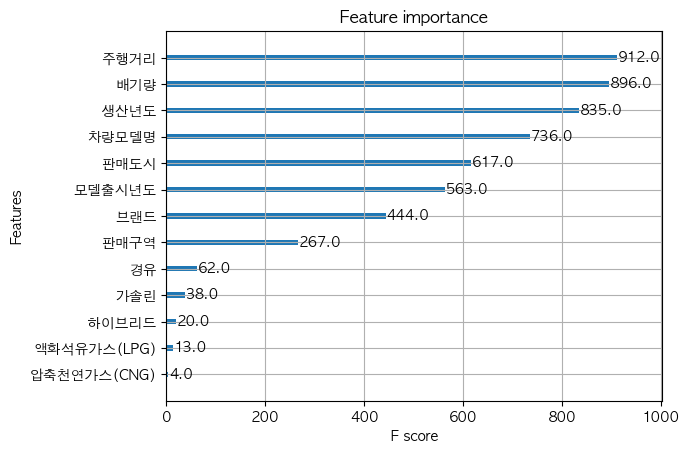

In [24]:
model = XGBRegressor(random_state=11)
model.fit(X_train, y_train)

plot_importance(model)

In [21]:
perm = PermutationImportance(model, scoring = "neg_mean_absolute_error", random_state = 22).fit(X_val, y_val) 
eli5.show_weights(perm, top = 20, feature_names = X_val.columns.tolist())

Weight,Feature
21.8727 ± 0.2073,생산년도
8.3636 ± 0.1274,배기량
4.2531 ± 0.0726,차량모델명
3.6958 ± 0.1070,주행거리
3.4280 ± 0.0770,모델출시년도
3.3997 ± 0.0528,브랜드
0.3156 ± 0.0350,경유
0.1353 ± 0.0191,판매도시
0.1055 ± 0.0308,판매구역
0.0620 ± 0.0128,가솔린


In [ ]:
model = XGBRegressor(random_stste =42)
model.fit(X_train,y_train)



[16:51:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "random_stste" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

생산년도, 배기량, 

Feature Importance에서 `주행거리, 배기량, 생산년도, 모델출시년도, 차량모델명, 브랜드, 판매도시`는 중요도가 높은것을 나타남. 
`판매구역`은 Feature Importance에서  큰 영향을 받지 못한것으로  판단되므로 삭제함.

In [37]:
X_train.drop(['판매구역'],axis=1,inplace=True)
X_val.drop(['판매구역'],axis=1,inplace=True)
test.drop(['판매구역'],axis=1,inplace=True)
X_train_k.drop(['판매구역'],axis=1,inplace=True)


## Optuna

In [ ]:
def objectiveXGB2(trial: Trial, X_train, y_train,X_val,y_val ):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        'reg_lambda' : trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'reg_alpha' : trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'random_state' : trial.suggest_int('random_state',10,50)
    }

    # 학습 모델 생성
    model = XGBRegressor(**param,tree_method='gpu_hist',gpu_id=0)
    xgb_model = model.fit(X_train, y_train, verbose=True) # 학습 진행

    # 모델 성능 확인
    score = mean_absolute_error(xgb_model.predict(X_val), y_val)

    return score

In [ ]:
# MAE가 최소가 되는 방향으로 학습을 진행
# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study2 = optuna.create_study(direction='minimize', sampler=TPESampler())

# n_trials 지정해주지 않으면, 무한 반복
study2.optimize(lambda trial : objectiveXGB2(trial, X_train, y_train, X_val,y_val), n_trials = 80)

print('Best trial : score {}, \nparams {}'.format(study2.best_trial.value, study2.best_trial.params))

[I 2023-06-23 16:57:42,750] A new study created in memory with name: no-name-106eefe7-d602-494d-beb3-359cfa39b16e
[I 2023-06-23 16:57:54,880] Trial 0 finished with value: 6.354954014256679 and parameters: {'n_estimators': 2192, 'max_depth': 16, 'min_child_weight': 256, 'gamma': 2, 'colsample_bytree': 1.0, 'reg_lambda': 0.33734294342457805, 'reg_alpha': 0.012494827784214697, 'subsample': 0.7, 'random_state': 38}. Best is trial 0 with value: 6.354954014256679.
[I 2023-06-23 16:57:57,516] Trial 1 finished with value: 7.08627913513401 and parameters: {'n_estimators': 525, 'max_depth': 14, 'min_child_weight': 259, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.6356538602931953, 'reg_alpha': 0.0243164269327583, 'subsample': 0.7, 'random_state': 48}. Best is trial 0 with value: 6.354954014256679.
[I 2023-06-23 16:58:12,696] Trial 2 finished with value: 6.16200282192856 and parameters: {'n_estimators': 3930, 'max_depth': 10, 'min_child_weight': 203, 'gamma': 2, 'colsample_bytree': 0.8, '

Best trial : score 5.774518036632413, 
params {'n_estimators': 2816, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 3, 'colsample_bytree': 0.5, 'reg_lambda': 0.004321841156000483, 'reg_alpha': 0.0018634819857144289, 'subsample': 0.8, 'random_state': 29}


In [ ]:
print('Best trial : score {}, \nparams {}'.format(study2.best_trial.value, study2.best_trial.params))

Best trial : score 5.774518036632413, 
params {'n_estimators': 2816, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 3, 'colsample_bytree': 0.5, 'reg_lambda': 0.004321841156000483, 'reg_alpha': 0.0018634819857144289, 'subsample': 0.8, 'random_state': 29}


In [ ]:
#최적화 파라마터
study2.best_trial.params

{'n_estimators': 2816,
 'max_depth': 9,
 'min_child_weight': 1,
 'gamma': 3,
 'colsample_bytree': 0.5,
 'reg_lambda': 0.004321841156000483,
 'reg_alpha': 0.0018634819857144289,
 'subsample': 0.8,
 'random_state': 29}

In [ ]:
model_xgb2= XGBRegressor(n_estimators = 2816,
                         max_depth = 9,
                         min_child_weight = 1,
                         gamma = 3,
                         colsample_bytree = 0.5,
                         reg_lambda = 0.004321841156000483,
                         reg_alpha = 0.0018634819857144289,
                         subsample = 0.8,
                         random_state = 29,
                         learning_rate = 0.01,
                         nthread = -1,
                         tree_method='gpu_hist',
                         gpu_id=0)



In [ ]:
model_xgb2.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=2816, n_jobs=None, nthread=-1, num_parallel_tree=None,
             predictor=None, ...)

## K-Fold & Optuna


In [40]:
def objectiveXGB_k(trial):
  score=[]
  kf=KFold(n_splits=5,random_state=42,shuffle=True)
  for train_fold, test_fold in tqdm_notebook(kf.split(X_train_k, y_train_k), desc = 'k_fold'):
        X_train, X_test, y_train, y_test = X_train_k.iloc[train_fold], X_train_k.iloc[test_fold], y_train_k[train_fold], y_train_k[test_fold]

        param = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        'reg_lambda' : trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'reg_alpha' : trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'random_state' : trial.suggest_int('random_state',10,50)
        }

        # 학습 모델 생성
        model = XGBRegressor(**param,tree_method='gpu_hist',gpu_id=0)
        xgb_model = model.fit(X_train, y_train, verbose=True) # 학습 진행

        # 모델 성능 확인
        score_cv = mean_absolute_error(xgb_model.predict(X_test), y_test)
        score.append(score_cv)

  return np.mean(score)

In [42]:
study_k = optuna.create_study(direction='minimize', sampler=TPESampler())

# n_trials 지정해주지 않으면, 무한 반복
study_k.optimize( objectiveXGB_k,n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study_k.best_trial.value, study_k.best_trial.params))

[I 2023-06-25 06:14:09,793] A new study created in memory with name: no-name-4bd0b053-d1ea-4c65-87b9-4eab3e2e9413


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:15:09,134] Trial 0 finished with value: 5.893509495922544 and parameters: {'n_estimators': 1095, 'max_depth': 16, 'min_child_weight': 27, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.1820889651182561, 'reg_alpha': 0.04411859928379658, 'subsample': 0.6, 'random_state': 43}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:15:42,442] Trial 1 finished with value: 6.220494107852243 and parameters: {'n_estimators': 1051, 'max_depth': 15, 'min_child_weight': 108, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 2.459223787675522, 'reg_alpha': 8.22879514950104, 'subsample': 0.6, 'random_state': 45}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:16:11,736] Trial 2 finished with value: 6.065365798256098 and parameters: {'n_estimators': 1235, 'max_depth': 10, 'min_child_weight': 56, 'gamma': 1, 'colsample_bytree': 0.7, 'reg_lambda': 0.0030509156628580002, 'reg_alpha': 0.1338042951268075, 'subsample': 0.6, 'random_state': 32}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:16:25,567] Trial 3 finished with value: 6.973631521282111 and parameters: {'n_estimators': 616, 'max_depth': 10, 'min_child_weight': 201, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.26418452919750335, 'reg_alpha': 1.1454876031741403, 'subsample': 0.6, 'random_state': 12}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:17:50,584] Trial 4 finished with value: 6.2889976127557246 and parameters: {'n_estimators': 3518, 'max_depth': 14, 'min_child_weight': 294, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.03083993519302039, 'reg_alpha': 1.1253212966747714, 'subsample': 0.7, 'random_state': 21}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:19:01,565] Trial 5 finished with value: 5.951570367821508 and parameters: {'n_estimators': 2131, 'max_depth': 14, 'min_child_weight': 64, 'gamma': 1, 'colsample_bytree': 0.9, 'reg_lambda': 0.00315949399649104, 'reg_alpha': 0.9439817578885091, 'subsample': 0.7, 'random_state': 45}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:19:28,051] Trial 6 finished with value: 6.677838895181348 and parameters: {'n_estimators': 1455, 'max_depth': 9, 'min_child_weight': 243, 'gamma': 3, 'colsample_bytree': 0.5, 'reg_lambda': 0.0019327358435908136, 'reg_alpha': 0.0021093372685222927, 'subsample': 0.6, 'random_state': 20}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:20:33,314] Trial 7 finished with value: 6.264859488434781 and parameters: {'n_estimators': 2759, 'max_depth': 13, 'min_child_weight': 208, 'gamma': 2, 'colsample_bytree': 0.6, 'reg_lambda': 0.06649802381475713, 'reg_alpha': 0.2998897518352663, 'subsample': 0.6, 'random_state': 12}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:21:24,672] Trial 8 finished with value: 6.299691036336978 and parameters: {'n_estimators': 2943, 'max_depth': 9, 'min_child_weight': 288, 'gamma': 2, 'colsample_bytree': 0.7, 'reg_lambda': 7.7533008222531485, 'reg_alpha': 1.7507651912268378, 'subsample': 0.8, 'random_state': 41}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:21:44,712] Trial 9 finished with value: 7.0029126072824 and parameters: {'n_estimators': 886, 'max_depth': 12, 'min_child_weight': 282, 'gamma': 2, 'colsample_bytree': 0.5, 'reg_lambda': 0.007987079474664757, 'reg_alpha': 1.4872065408686868, 'subsample': 0.6, 'random_state': 50}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:24:18,147] Trial 10 finished with value: 6.174974106613352 and parameters: {'n_estimators': 2015, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 1, 'colsample_bytree': 1.0, 'reg_lambda': 0.16635176214477096, 'reg_alpha': 0.020657308139227684, 'subsample': 1.0, 'random_state': 35}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:25:25,939] Trial 11 finished with value: 6.001135328065625 and parameters: {'n_estimators': 1983, 'max_depth': 16, 'min_child_weight': 93, 'gamma': 1, 'colsample_bytree': 0.9, 'reg_lambda': 0.02028038452374106, 'reg_alpha': 0.05557728205443583, 'subsample': 0.7, 'random_state': 40}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:28:48,240] Trial 12 finished with value: 6.014685608627799 and parameters: {'n_estimators': 1673, 'max_depth': 14, 'min_child_weight': 3, 'gamma': 1, 'colsample_bytree': 0.9, 'reg_lambda': 0.0012770545995681086, 'reg_alpha': 0.016464448729891275, 'subsample': 0.7, 'random_state': 48}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:29:59,973] Trial 13 finished with value: 5.90491430703703 and parameters: {'n_estimators': 2638, 'max_depth': 12, 'min_child_weight': 52, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.32691788874872446, 'reg_alpha': 0.2301729579405492, 'subsample': 1.0, 'random_state': 39}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:31:04,578] Trial 14 finished with value: 6.025119773904066 and parameters: {'n_estimators': 2681, 'max_depth': 12, 'min_child_weight': 140, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.5676102951078561, 'reg_alpha': 0.16865372252638117, 'subsample': 1.0, 'random_state': 26}. Best is trial 0 with value: 5.893509495922544.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:32:29,406] Trial 15 finished with value: 5.877579550762286 and parameters: {'n_estimators': 3997, 'max_depth': 11, 'min_child_weight': 40, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.7300888939683912, 'reg_alpha': 0.04183805916889331, 'subsample': 1.0, 'random_state': 37}. Best is trial 15 with value: 5.877579550762286.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:34:10,428] Trial 16 finished with value: 5.880889660740961 and parameters: {'n_estimators': 3920, 'max_depth': 11, 'min_child_weight': 30, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.9206510666734614, 'reg_alpha': 0.03277449709885333, 'subsample': 0.8, 'random_state': 35}. Best is trial 15 with value: 5.877579550762286.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:35:38,415] Trial 17 finished with value: 6.029640917696311 and parameters: {'n_estimators': 3944, 'max_depth': 11, 'min_child_weight': 126, 'gamma': 2, 'colsample_bytree': 1.0, 'reg_lambda': 1.1288275128941854, 'reg_alpha': 0.006860040782121746, 'subsample': 0.8, 'random_state': 29}. Best is trial 15 with value: 5.877579550762286.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:36:38,821] Trial 18 finished with value: 5.978608106959216 and parameters: {'n_estimators': 3852, 'max_depth': 8, 'min_child_weight': 84, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 1.16148589892958, 'reg_alpha': 0.0013316872701669693, 'subsample': 0.8, 'random_state': 35}. Best is trial 15 with value: 5.877579550762286.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:37:49,918] Trial 19 finished with value: 6.095225002281409 and parameters: {'n_estimators': 3269, 'max_depth': 11, 'min_child_weight': 180, 'gamma': 2, 'colsample_bytree': 0.9, 'reg_lambda': 3.9968164968286657, 'reg_alpha': 0.006224369324738214, 'subsample': 0.8, 'random_state': 36}. Best is trial 15 with value: 5.877579550762286.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:39:08,059] Trial 20 finished with value: 5.855858514787598 and parameters: {'n_estimators': 3439, 'max_depth': 11, 'min_child_weight': 31, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.7154375964909937, 'reg_alpha': 0.06466057425080252, 'subsample': 1.0, 'random_state': 27}. Best is trial 20 with value: 5.855858514787598.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:40:30,573] Trial 21 finished with value: 5.870549127401342 and parameters: {'n_estimators': 3574, 'max_depth': 11, 'min_child_weight': 36, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.7685532422086054, 'reg_alpha': 0.0753817987892763, 'subsample': 1.0, 'random_state': 25}. Best is trial 20 with value: 5.855858514787598.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:41:46,011] Trial 22 finished with value: 5.874165745875834 and parameters: {'n_estimators': 3441, 'max_depth': 10, 'min_child_weight': 40, 'gamma': 2, 'colsample_bytree': 0.8, 'reg_lambda': 0.4726349335727443, 'reg_alpha': 0.07574943973641617, 'subsample': 1.0, 'random_state': 23}. Best is trial 20 with value: 5.855858514787598.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:42:57,239] Trial 23 finished with value: 5.933698379949992 and parameters: {'n_estimators': 3424, 'max_depth': 10, 'min_child_weight': 75, 'gamma': 2, 'colsample_bytree': 0.7, 'reg_lambda': 0.41167222191559766, 'reg_alpha': 0.08618425025976628, 'subsample': 1.0, 'random_state': 21}. Best is trial 20 with value: 5.855858514787598.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:43:54,020] Trial 24 finished with value: 6.043965280938101 and parameters: {'n_estimators': 3115, 'max_depth': 9, 'min_child_weight': 114, 'gamma': 2, 'colsample_bytree': 0.9, 'reg_lambda': 2.0677532997406725, 'reg_alpha': 0.09428825742074512, 'subsample': 1.0, 'random_state': 25}. Best is trial 20 with value: 5.855858514787598.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:45:03,129] Trial 25 finished with value: 5.814416805001459 and parameters: {'n_estimators': 3604, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 3, 'colsample_bytree': 0.8, 'reg_lambda': 0.09073640949508727, 'reg_alpha': 0.29464201845781357, 'subsample': 1.0, 'random_state': 17}. Best is trial 25 with value: 5.814416805001459.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:46:11,467] Trial 26 finished with value: 5.7919155939135765 and parameters: {'n_estimators': 3598, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.10110175635422138, 'reg_alpha': 0.35132537113277107, 'subsample': 1.0, 'random_state': 15}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:47:19,591] Trial 27 finished with value: 5.799126569229019 and parameters: {'n_estimators': 3661, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.11225084098436645, 'reg_alpha': 0.3276265047452273, 'subsample': 1.0, 'random_state': 18}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:48:08,645] Trial 28 finished with value: 5.819246212600921 and parameters: {'n_estimators': 2474, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.05782230684771442, 'reg_alpha': 0.4354266631498557, 'subsample': 1.0, 'random_state': 16}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:49:02,627] Trial 29 finished with value: 5.827416143459343 and parameters: {'n_estimators': 3056, 'max_depth': 8, 'min_child_weight': 13, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.1315698375293003, 'reg_alpha': 0.5201223644911592, 'subsample': 1.0, 'random_state': 16}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:50:04,153] Trial 30 finished with value: 5.828356028827473 and parameters: {'n_estimators': 3659, 'max_depth': 8, 'min_child_weight': 21, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.09522748538398326, 'reg_alpha': 0.1750939245693941, 'subsample': 1.0, 'random_state': 16}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:50:51,417] Trial 31 finished with value: 5.818895806216116 and parameters: {'n_estimators': 2490, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.055915192077128854, 'reg_alpha': 0.48396621193499173, 'subsample': 1.0, 'random_state': 16}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:52:05,553] Trial 32 finished with value: 5.804655351006277 and parameters: {'n_estimators': 3712, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.1939975886410674, 'reg_alpha': 0.3747566619222802, 'subsample': 1.0, 'random_state': 10}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:53:18,534] Trial 33 finished with value: 5.8881643347829495 and parameters: {'n_estimators': 3718, 'max_depth': 9, 'min_child_weight': 47, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.2059897323436418, 'reg_alpha': 0.2907094877057276, 'subsample': 1.0, 'random_state': 10}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:54:27,487] Trial 34 finished with value: 5.917678534230146 and parameters: {'n_estimators': 3775, 'max_depth': 9, 'min_child_weight': 66, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.19813375907051353, 'reg_alpha': 2.4998374749613665, 'subsample': 1.0, 'random_state': 13}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:55:21,780] Trial 35 finished with value: 5.836936111161701 and parameters: {'n_estimators': 3216, 'max_depth': 8, 'min_child_weight': 21, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.22772426074662813, 'reg_alpha': 0.6689879663942473, 'subsample': 1.0, 'random_state': 19}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:56:17,184] Trial 36 finished with value: 5.919932702057063 and parameters: {'n_estimators': 2935, 'max_depth': 9, 'min_child_weight': 57, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.12294705407931761, 'reg_alpha': 0.1432964688828301, 'subsample': 1.0, 'random_state': 14}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:57:26,321] Trial 37 finished with value: 5.955975556391626 and parameters: {'n_estimators': 3315, 'max_depth': 10, 'min_child_weight': 90, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.03677204254449999, 'reg_alpha': 0.23600446098209396, 'subsample': 1.0, 'random_state': 10}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:58:26,631] Trial 38 finished with value: 5.853233017297205 and parameters: {'n_estimators': 3629, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.09635524640644351, 'reg_alpha': 0.3572926217123388, 'subsample': 0.7, 'random_state': 18}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 06:59:17,754] Trial 39 finished with value: 6.271013473516772 and parameters: {'n_estimators': 2888, 'max_depth': 9, 'min_child_weight': 167, 'gamma': 3, 'colsample_bytree': 0.5, 'reg_lambda': 0.35728657363524213, 'reg_alpha': 0.7443443971721088, 'subsample': 0.6, 'random_state': 14}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:00:16,039] Trial 40 finished with value: 6.21154592275036 and parameters: {'n_estimators': 3696, 'max_depth': 8, 'min_child_weight': 240, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.01804890164545739, 'reg_alpha': 0.12156567510641784, 'subsample': 1.0, 'random_state': 23}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:01:02,838] Trial 41 finished with value: 5.8141984139745695 and parameters: {'n_estimators': 2476, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.052299711259749256, 'reg_alpha': 0.4662943286009332, 'subsample': 1.0, 'random_state': 17}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:01:42,435] Trial 42 finished with value: 5.849178942683116 and parameters: {'n_estimators': 1756, 'max_depth': 9, 'min_child_weight': 16, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.07947002218664964, 'reg_alpha': 0.9473654871492498, 'subsample': 1.0, 'random_state': 18}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:02:05,981] Trial 43 finished with value: 5.955698203472349 and parameters: {'n_estimators': 1100, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.14929859718623933, 'reg_alpha': 0.27054236839802726, 'subsample': 1.0, 'random_state': 11}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:02:51,726] Trial 44 finished with value: 5.922842194634577 and parameters: {'n_estimators': 2307, 'max_depth': 9, 'min_child_weight': 34, 'gamma': 3, 'colsample_bytree': 0.8, 'reg_lambda': 0.04307162071066647, 'reg_alpha': 0.7114164079583495, 'subsample': 0.6, 'random_state': 14}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:03:41,942] Trial 45 finished with value: 5.962348686157514 and parameters: {'n_estimators': 3139, 'max_depth': 8, 'min_child_weight': 68, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.07861951524193835, 'reg_alpha': 0.43040825051733034, 'subsample': 1.0, 'random_state': 22}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:03:58,573] Trial 46 finished with value: 6.265619623569659 and parameters: {'n_estimators': 514, 'max_depth': 10, 'min_child_weight': 50, 'gamma': 3, 'colsample_bytree': 0.8, 'reg_lambda': 0.02391346000288581, 'reg_alpha': 0.1977504103018114, 'subsample': 0.7, 'random_state': 12}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:05:02,170] Trial 47 finished with value: 5.798758004318286 and parameters: {'n_estimators': 3520, 'max_depth': 9, 'min_child_weight': 14, 'gamma': 3, 'colsample_bytree': 0.6, 'reg_lambda': 0.24587039779463285, 'reg_alpha': 1.367459321595167, 'subsample': 1.0, 'random_state': 18}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:06:10,520] Trial 48 finished with value: 5.79732186819613 and parameters: {'n_estimators': 3324, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 3, 'colsample_bytree': 0.5, 'reg_lambda': 0.23922582262393158, 'reg_alpha': 1.4726813337889846, 'subsample': 1.0, 'random_state': 21}. Best is trial 26 with value: 5.7919155939135765.


k_fold: 0it [00:00, ?it/s]

[I 2023-06-25 07:07:29,991] Trial 49 finished with value: 5.842114077648221 and parameters: {'n_estimators': 3350, 'max_depth': 10, 'min_child_weight': 22, 'gamma': 3, 'colsample_bytree': 0.5, 'reg_lambda': 0.28770356822685245, 'reg_alpha': 2.847008945630681, 'subsample': 0.6, 'random_state': 20}. Best is trial 26 with value: 5.7919155939135765.


Best trial : score 5.7919155939135765, 
params {'n_estimators': 3598, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.10110175635422138, 'reg_alpha': 0.35132537113277107, 'subsample': 1.0, 'random_state': 15}


params {n_estimators = 3598, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 3, 'colsample_bytree': 0.7, 'reg_lambda': 0.10110175635422138, 'reg_alpha': 0.35132537113277107, 'subsample': 1.0, 'random_state': 15}

In [49]:


model_k = XGBRegressor(learning_rate=0.01,
                        nthread=-1,
                        n_estimators = 3598,
                        max_depth = 8,
                        min_child_weight = 2,
                        gamma = 3,
                        colsample_bytree=0.7,
                        reg_lambda = 0.10110175635422138,
                        reg_alpha = 0.35132537113277107,
                        subsample = 1.0,
                        random_state= 15,
                       tree_method='gpu_hist',
                         gpu_id=0)
model_k.fit(X_train_k, y_train_k)
pred_k=  model_k.predict(test)

결과  
- K-fold & optuna :  5.7919155939135765  
- optuna :  5.774518036632413

제출

In [ ]:
pred2=model_xgb2.predict(test)

In [50]:
sample_submission = pd.read_csv('/content/drive/MyDrive/사이드프로젝트 /car_price/sample_submission.csv')
sample_submission['가격'] = pred_k
sample_submission.to_csv("submit_xgb_K.csv", index = False)